## 10-fold CV with 3-layer CNN avg pooling

### Import and env settings

In [95]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import os

In [96]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 50)

### Variables/parameters used in this notebook

In [97]:
file = '../../data/home_sale_data_324_features_10_class.csv'

ckpt_path = "./ckpt/10_class_lr005/"
os.makedirs(ckpt_path, exist_ok=True)

num_classes = 10
lr = 0.005
epochs = 120

### Prepare data

In [98]:
data = pd.read_csv(file)

'''suffle rows randomly'''
data = data.sample(frac=1)

labels = data['label']

data.head()

,OverallQual,GrLivArea,TotalSF,GarageCars,Total_Bathrooms,GarageArea,YrBltAndRemod,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,YearRemodAdd,Foundation_PConc,TotRmsAbvGrd,hasfireplace,ExterQual_Gd,BsmtQual_Ex,Fireplaces,HeatingQC_Ex,MasVnrArea,Total_porch_sf,BsmtFinType1_GLQ,KitchenQual_Ex,OpenPorchSF,GarageFinish_Fin,...,BsmtExposure_No,Neighborhood_OldTown,Foundation_BrkTil,GarageFinish_None,GarageCond_None,GarageQual_None,GarageType_None,MSSubClass_30,LotShape_Reg,PavedDrive_N,Foundation_CBlock,MSZoning_RM,HeatingQC_TA,CentralAir_N,GarageType_Detchd,MasVnrType_None,GarageFinish_Unf,BsmtQual_TA,FireplaceQu_None,KitchenQual_TA,ExterQual_TA,dummy_1,dummy_2,dummy_3,label
369,0.333333,0.584815,0.111736,0.4,0.164976,0.456989,0.463158,0.000000,0.495831,0.630435,0.50,0.150000,0.0,0.600315,1.0,0.0,0.0,0.293793,0.0,0.000000,0.077734,0.0,0.0,0.282859,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,p7
576,0.555556,0.543753,0.231395,0.4,0.059256,0.384409,0.615789,0.356831,0.595861,0.637681,0.25,0.616667,0.0,0.600315,1.0,0.0,0.0,0.549061,1.0,0.258795,0.404908,0.0,0.0,0.390999,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,p3
2532,0.555556,0.515934,0.268954,0.4,0.164976,0.293683,0.963158,0.414847,0.566380,0.971015,0.50,0.950000,1.0,0.516936,1.0,1.0,0.0,0.293793,1.0,0.000000,0.046366,0.0,0.0,0.168717,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,p3
1724,0.444444,0.350917,0.174730,0.4,0.163872,0.491936,0.484211,0.269495,0.389345,0.644928,0.25,0.183333,0.0,0.421336,0.0,0.0,0.0,0.000000,1.0,0.000000,0.180810,1.0,0.0,0.657933,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,p7
2842,0.666667,0.684929,0.455353,0.4,0.252530,0.313844,0.857895,0.332190,0.475164,0.898551,0.50,0.783333,1.0,0.740833,1.0,1.0,0.0,0.293793,1.0,0.000000,0.272142,0.0,0.0,0.253387,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,p2


In [99]:
# drop label column
data.drop(['label'], axis=1, inplace=True)
data.describe()

,OverallQual,GrLivArea,TotalSF,GarageCars,Total_Bathrooms,GarageArea,YrBltAndRemod,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,YearRemodAdd,Foundation_PConc,TotRmsAbvGrd,hasfireplace,ExterQual_Gd,BsmtQual_Ex,Fireplaces,HeatingQC_Ex,MasVnrArea,Total_porch_sf,BsmtFinType1_GLQ,KitchenQual_Ex,OpenPorchSF,GarageFinish_Fin,...,Neighborhood_IDOTRR,BsmtExposure_No,Neighborhood_OldTown,Foundation_BrkTil,GarageFinish_None,GarageCond_None,GarageQual_None,GarageType_None,MSSubClass_30,LotShape_Reg,PavedDrive_N,Foundation_CBlock,MSZoning_RM,HeatingQC_TA,CentralAir_N,GarageType_Detchd,MasVnrType_None,GarageFinish_Unf,BsmtQual_TA,FireplaceQu_None,KitchenQual_TA,ExterQual_TA,dummy_1,dummy_2,dummy_3
count,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,...,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.0,2911.0,2911.0
mean,0.565136,0.542763,0.293431,0.353143,0.200863,0.317285,0.660811,0.326706,0.487996,0.719569,0.391876,0.570892,0.447956,0.542786,0.512882,0.335967,0.087255,0.171718,0.511508,0.159954,0.203170,0.290622,0.069392,0.176542,0.245620,...,0.031261,0.652697,0.082102,0.106493,0.054277,0.054277,0.054277,0.053590,0.047750,0.637582,0.073514,0.423222,0.158708,0.293370,0.066644,0.266919,0.605634,0.421848,0.439368,0.487118,0.511852,0.616627,0.0,0.0,0.0
std,0.155988,0.125193,0.119772,0.152244,0.133043,0.143976,0.242686,0.131930,0.131369,0.219351,0.138140,0.348189,0.497369,0.128554,0.499920,0.472409,0.282257,0.181727,0.499953,0.218350,0.163524,0.454127,0.254163,0.183129,0.430528,...,0.174051,0.476195,0.274568,0.308520,0.226602,0.226602,0.226602,0.225245,0.213273,0.480781,0.261024,0.494155,0.365467,0.455385,0.249447,0.442425,0.488798,0.493939,0.496395,0.499920,0.499945,0.486292,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,0.444444,0.451636,0.213557,0.200000,0.088659,0.215054,0.473684,0.247193,0.395003,0.590580,0.250000,0.250000,0.000000,0.421336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066964,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,0.555556,0.547807,0.282326,0.400000,0.164976,0.322581,0.652632,0.308172,0.481664,0.731884,0.500000,0.716667,0.000000,0.516936,1.000000,0.000000,0.000000,0.293793,1.000000,0.000000,0.179849,0.000000,0.000000,0.180865,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.0,0.0
75%,0.666667,0.621247,0.356447,0.400000,0.252530,0.387097,0.905263,0.405490,0.582574,0.934783,0.500000,0.900000,1.000000,0.600315,1.000000,1.000000,0.000000,0.293793,1.000000,0.353218,0.327089,1.000000,0.000000,0.309510,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,

In [100]:
labels.unique()

array(['p7', 'p3', 'p2', 'p8', 'p9', 'p0', 'p4', 'p5', 'p6', 'p1'],
      dtype=object)

In [101]:
'''one-hot encode the labels'''

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
# print(list(integer_encoded))

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
labels = onehot_encoder.fit_transform(integer_encoded)

print('Number of classes: ', len(labels[0]))
print(labels)

Number of classes:  10
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [102]:
data_np = data.to_numpy()
data_np.shape
data_np = data_np.reshape(len(data), 18, 18)
data_np.shape

(2911, 18, 18)

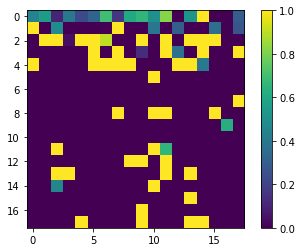

In [103]:
# data_np[0].shape

nArray = np.array(data_np[99])


a11=nArray.reshape(18,18)
plt.imshow(a11)
plt.colorbar()
plt.show()

In [104]:
labels.shape

(2911, 10)

In [105]:
all_examples = data_np
all_examples.shape

(2911, 18, 18)

#### train test splitting
- hold out 15% for testing
- use 85% to train model with K-fold CV

In [106]:
ttl_samples = all_examples.shape[0] 
test_ratio = 0.15
test_samples = int(test_ratio * all_examples.shape[0])

train_examples = all_examples[:-1*test_samples]
test_examples = all_examples[-1*test_samples:]

train_labels = labels[:-1*test_samples]
test_labels = labels[-1*test_samples:]


In [107]:
print('train: ', train_examples.shape)
print('test: ', test_examples.shape)
print('train label: ', train_labels.shape)
print('test label: ', test_labels.shape)

train:  (2475, 18, 18)
test:  (436, 18, 18)
train label:  (2475, 10)
test label:  (436, 10)


In [108]:
# trainX = train_examples.reshape(ttl_samples-test_samples, 18,18,1)
# trainY = train_labels

# testX = test_examples.reshape(test_samples, 18,18,1)
# testY = test_labels


### Prepare model

In [109]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')


def create_model(num_classes=5, lr=0.005):

	# Working
	with tf.device('/cpu:0'):
		data_augmentation = tf.keras.Sequential([ 
			tf.keras.layers.RandomFlip("horizontal", input_shape=(18, 18, 1)),
	  		tf.keras.layers.RandomRotation(0.1),
		    tf.keras.layers.RandomZoom(0.1)
			])


	model = tf.keras.Sequential([
		# data_augmentation,
	  	# tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
	  	tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(18, 18, 1)),
		tf.keras.layers.MaxPooling2D((2, 2)),
		tf.keras.layers.Dropout(0.1),
		tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
	  	tf.keras.layers.MaxPooling2D((2,2)),
		tf.keras.layers.Dropout(0.1),
	  	tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
	  	tf.keras.layers.MaxPooling2D(),
		tf.keras.layers.Dropout(0.1),
		tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(128, activation='relu'),
		tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
	])

	# opt = tf.keras.optimizers.SGD(lr=0.005, momentum=0.9)
	opt = tf.keras.optimizers.Adam(lr=lr)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

	return model



Num GPUs Available:  1


In [89]:
model = create_model()
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 18, 18, 16)        160       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 9, 9, 16)         0         
 g2D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 9, 9, 16)          0         
                                                                 
 conv2d_28 (Conv2D)          (None, 9, 9, 32)          4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 4, 4, 32)         0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 4, 4, 32)        

/Users/evantilu/miniforge3/envs/6998_DL_tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Training

In [17]:
from sklearn.model_selection import KFold

# modify to save ckpt for each test
ckpt = os.path.join(ckpt_path, "val_acc_{val_accuracy:.3f}.hdf5")

# training params
epochs = epochs
num_classes = num_classes
lr = lr

# the k for k fold CV
n_split = 10

# for recording best performance
max_acc = 0
best_history = None

'''
k-fold cross validation
Save the best model using validation accuracy as metric
Print the global best performace when finished
'''
for train_index, test_index in KFold(n_split).split(train_examples):

    x_train, x_vad = train_examples[train_index], train_examples[test_index]
    y_train, y_vad = train_labels[train_index], train_labels[test_index]

    model=create_model(num_classes, lr)
  
    # callbacks
    checkpoint_filepath = ckpt
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        mode='auto',
    )

    # Model weights are saved at the end of every epoch, if it's the best seen so far.
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_vad, y_vad),
                        callbacks=[model_checkpoint_callback, early_stopping_callback])

    val_acc = max(history.history['val_accuracy'])
    
    if val_acc > max_acc:
        max_acc = val_acc
        best_history = history
        # print('Best acc so far. Saving params...\n')

print('Finish {}-fold cross validation'.format(n_split))
print('Best performing model has {:.4f} validation accuracy'.format(max_acc))

#CPU
# with tf.device('/CPU:0'):
#     history = model.fit(trainX, trainY, epochs=epochs,validation_data=(testX, testY), batch_size=64)

# deafult go with GPU
# history = model.fit(trainX, trainY, epochs=epochs,validation_data=(testX, testY), batch_size=64)

Epoch 1/120


2022-04-30 11:55:23.714938: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-30 11:55:24.004055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.1972 - accuracy: 0.4603

2022-04-30 11:55:28.427078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.56855, saving model to ./ckpt/5_class_lr005_new/val_acc_0.569.hdf5
70/70 [==============================] - 5s 30ms/step - loss: 1.1972 - accuracy: 0.4603 - val_loss: 1.0213 - val_accuracy: 0.5685
Epoch 2/120
69/70 [============================>.] - ETA: 0s - loss: 0.9591 - accuracy: 0.5793
Epoch 2: val_accuracy improved from 0.56855 to 0.57661, saving model to ./ckpt/5_class_lr005_new/val_acc_0.577.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 0.9565 - accuracy: 0.5806 - val_loss: 0.9917 - val_accuracy: 0.5766
Epoch 3/120
70/70 [==============================] - ETA: 0s - loss: 0.8840 - accuracy: 0.6071
Epoch 3: val_accuracy improved from 0.57661 to 0.60484, saving model to ./ckpt/5_class_lr005_new/val_acc_0.605.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 0.8840 - accuracy: 0.6071 - val_loss: 0.8394 - val_accuracy: 0.6048
Epoch 4/120
68/70 [============================>.] - ETA: 0s - loss: 0.794

2022-04-30 11:55:47.419290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.3185 - accuracy: 0.3776
Epoch 1: val_accuracy improved from -inf to 0.55242, saving model to ./ckpt/5_class_lr005_new/val_acc_0.552.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 1.3185 - accuracy: 0.3776 - val_loss: 0.9952 - val_accuracy: 0.5524
Epoch 2/120
 6/70 [=>............................] - ETA: 0s - loss: 1.1085 - accuracy: 0.4635

2022-04-30 11:55:48.386337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/70 [===========================>..] - ETA: 0s - loss: 0.9903 - accuracy: 0.5445
Epoch 2: val_accuracy improved from 0.55242 to 0.57661, saving model to ./ckpt/5_class_lr005_new/val_acc_0.577.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 0.9831 - accuracy: 0.5478 - val_loss: 0.9172 - val_accuracy: 0.5766
Epoch 3/120
69/70 [============================>.] - ETA: 0s - loss: 0.8262 - accuracy: 0.6255
Epoch 3: val_accuracy improved from 0.57661 to 0.64113, saving model to ./ckpt/5_class_lr005_new/val_acc_0.641.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 0.8272 - accuracy: 0.6246 - val_loss: 0.8471 - val_accuracy: 0.6411
Epoch 4/120
70/70 [==============================] - ETA: 0s - loss: 0.7902 - accuracy: 0.6417
Epoch 4: val_accuracy improved from 0.64113 to 0.66935, saving model to ./ckpt/5_class_lr005_new/val_acc_0.669.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 0.7902 - accuracy: 0.6417 - val_loss: 0.7346 - val_accura

2022-04-30 11:56:07.148784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.2661 - accuracy: 0.4167
Epoch 1: val_accuracy improved from -inf to 0.57661, saving model to ./ckpt/5_class_lr005_new/val_acc_0.577.hdf5
70/70 [==============================] - 2s 17ms/step - loss: 1.2661 - accuracy: 0.4167 - val_loss: 0.9746 - val_accuracy: 0.5766
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 0.9921 - accuracy: 0.5938

2022-04-30 11:56:08.291041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/70 [============================>.] - ETA: 0s - loss: 0.9741 - accuracy: 0.5565
Epoch 2: val_accuracy improved from 0.57661 to 0.63710, saving model to ./ckpt/5_class_lr005_new/val_acc_0.637.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 0.9703 - accuracy: 0.5573 - val_loss: 0.8369 - val_accuracy: 0.6371
Epoch 3/120
68/70 [============================>.] - ETA: 0s - loss: 0.8368 - accuracy: 0.6305
Epoch 3: val_accuracy improved from 0.63710 to 0.67339, saving model to ./ckpt/5_class_lr005_new/val_acc_0.673.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 0.8381 - accuracy: 0.6300 - val_loss: 0.7675 - val_accuracy: 0.6734
Epoch 4/120
69/70 [============================>.] - ETA: 0s - loss: 0.7651 - accuracy: 0.6517
Epoch 4: val_accuracy improved from 0.67339 to 0.73790, saving model to ./ckpt/5_class_lr005_new/val_acc_0.738.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 0.7654 - accuracy: 0.6520 - val_loss: 0.6757 - val_accura

2022-04-30 11:56:28.011344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.3299 - accuracy: 0.3669
Epoch 1: val_accuracy improved from -inf to 0.44758, saving model to ./ckpt/5_class_lr005_new/val_acc_0.448.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 1.3299 - accuracy: 0.3669 - val_loss: 1.1447 - val_accuracy: 0.4476
Epoch 2/120
 1/70 [..............................] - ETA: 1s - loss: 1.2400 - accuracy: 0.4062

2022-04-30 11:56:29.036409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 0.9579 - accuracy: 0.5734
Epoch 2: val_accuracy improved from 0.44758 to 0.66532, saving model to ./ckpt/5_class_lr005_new/val_acc_0.665.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 0.9579 - accuracy: 0.5734 - val_loss: 0.8169 - val_accuracy: 0.6653
Epoch 3/120
69/70 [============================>.] - ETA: 0s - loss: 0.8955 - accuracy: 0.5969
Epoch 3: val_accuracy improved from 0.66532 to 0.68145, saving model to ./ckpt/5_class_lr005_new/val_acc_0.681.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 0.8939 - accuracy: 0.5981 - val_loss: 0.7631 - val_accuracy: 0.6815
Epoch 4/120
67/70 [===========================>..] - ETA: 0s - loss: 0.7687 - accuracy: 0.6651
Epoch 4: val_accuracy did not improve from 0.68145
70/70 [==============================] - 1s 14ms/step - loss: 0.7692 - accuracy: 0.6628 - val_loss: 0.7182 - val_accuracy: 0.6532
Epoch 5/120
69/70 [============================>.] - E

2022-04-30 11:56:46.666784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.2414 - accuracy: 0.4347
Epoch 1: val_accuracy improved from -inf to 0.60484, saving model to ./ckpt/5_class_lr005_new/val_acc_0.605.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 1.2414 - accuracy: 0.4347 - val_loss: 0.9424 - val_accuracy: 0.6048
Epoch 2/120
 6/70 [=>............................] - ETA: 0s - loss: 1.0268 - accuracy: 0.4948

2022-04-30 11:56:47.755270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/70 [===========================>..] - ETA: 0s - loss: 0.9362 - accuracy: 0.5843
Epoch 2: val_accuracy improved from 0.60484 to 0.63710, saving model to ./ckpt/5_class_lr005_new/val_acc_0.637.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 0.9353 - accuracy: 0.5882 - val_loss: 0.9005 - val_accuracy: 0.6371
Epoch 3/120
66/70 [===========================>..] - ETA: 0s - loss: 0.7881 - accuracy: 0.6728
Epoch 3: val_accuracy improved from 0.63710 to 0.67339, saving model to ./ckpt/5_class_lr005_new/val_acc_0.673.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 0.7905 - accuracy: 0.6704 - val_loss: 0.7783 - val_accuracy: 0.6734
Epoch 4/120
68/70 [============================>.] - ETA: 0s - loss: 0.7601 - accuracy: 0.6581
Epoch 4: val_accuracy did not improve from 0.67339
70/70 [==============================] - 1s 15ms/step - loss: 0.7620 - accuracy: 0.6578 - val_loss: 0.8273 - val_accuracy: 0.6653
Epoch 5/120
66/70 [===========================>..] - E

2022-04-30 11:57:11.110626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.2011 - accuracy: 0.4376

2022-04-30 11:57:12.521386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.59514, saving model to ./ckpt/5_class_lr005_new/val_acc_0.595.hdf5
70/70 [==============================] - 2s 22ms/step - loss: 1.2011 - accuracy: 0.4376 - val_loss: 0.9556 - val_accuracy: 0.5951
Epoch 2/120
68/70 [============================>.] - ETA: 0s - loss: 1.0046 - accuracy: 0.5528
Epoch 2: val_accuracy improved from 0.59514 to 0.59919, saving model to ./ckpt/5_class_lr005_new/val_acc_0.599.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 1.0021 - accuracy: 0.5530 - val_loss: 1.0075 - val_accuracy: 0.5992
Epoch 3/120
68/70 [============================>.] - ETA: 0s - loss: 0.8881 - accuracy: 0.5979
Epoch 3: val_accuracy improved from 0.59919 to 0.68826, saving model to ./ckpt/5_class_lr005_new/val_acc_0.688.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 0.8876 - accuracy: 0.5956 - val_loss: 0.7777 - val_accuracy: 0.6883
Epoch 4/120
68/70 [============================>.] - ETA: 0s - loss: 0.782

2022-04-30 11:57:30.756216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.2138 - accuracy: 0.4556
Epoch 1: val_accuracy improved from -inf to 0.36437, saving model to ./ckpt/5_class_lr005_new/val_acc_0.364.hdf5
70/70 [==============================] - 2s 16ms/step - loss: 1.2138 - accuracy: 0.4556 - val_loss: 1.1967 - val_accuracy: 0.3644
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 0.9085 - accuracy: 0.5000

2022-04-30 11:57:31.919344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/70 [===========================>..] - ETA: 0s - loss: 0.9809 - accuracy: 0.5578
Epoch 2: val_accuracy improved from 0.36437 to 0.57085, saving model to ./ckpt/5_class_lr005_new/val_acc_0.571.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 0.9821 - accuracy: 0.5543 - val_loss: 0.9253 - val_accuracy: 0.5709
Epoch 3/120
67/70 [===========================>..] - ETA: 0s - loss: 0.9052 - accuracy: 0.5979
Epoch 3: val_accuracy did not improve from 0.57085
70/70 [==============================] - 1s 13ms/step - loss: 0.9007 - accuracy: 0.6010 - val_loss: 0.9518 - val_accuracy: 0.5425
Epoch 4/120
68/70 [============================>.] - ETA: 0s - loss: 0.8167 - accuracy: 0.6466
Epoch 4: val_accuracy improved from 0.57085 to 0.67611, saving model to ./ckpt/5_class_lr005_new/val_acc_0.676.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 0.8124 - accuracy: 0.6486 - val_loss: 0.6887 - val_accuracy: 0.6761
Epoch 5/120
66/70 [===========================>..] - E

2022-04-30 11:57:55.182833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.2655 - accuracy: 0.4048
Epoch 1: val_accuracy improved from -inf to 0.53036, saving model to ./ckpt/5_class_lr005_new/val_acc_0.530.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 1.2655 - accuracy: 0.4048 - val_loss: 1.0821 - val_accuracy: 0.5304
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 1.0264 - accuracy: 0.4375

2022-04-30 11:57:56.243701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/70 [============================>.] - ETA: 0s - loss: 0.9790 - accuracy: 0.5684
Epoch 2: val_accuracy improved from 0.53036 to 0.59919, saving model to ./ckpt/5_class_lr005_new/val_acc_0.599.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 0.9800 - accuracy: 0.5669 - val_loss: 0.9851 - val_accuracy: 0.5992
Epoch 3/120
70/70 [==============================] - ETA: 0s - loss: 0.8940 - accuracy: 0.5943
Epoch 3: val_accuracy improved from 0.59919 to 0.60324, saving model to ./ckpt/5_class_lr005_new/val_acc_0.603.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 0.8940 - accuracy: 0.5943 - val_loss: 0.8999 - val_accuracy: 0.6032
Epoch 4/120
68/70 [============================>.] - ETA: 0s - loss: 0.7980 - accuracy: 0.6480
Epoch 4: val_accuracy improved from 0.60324 to 0.61134, saving model to ./ckpt/5_class_lr005_new/val_acc_0.611.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 0.7985 - accuracy: 0.6468 - val_loss: 0.8987 - val_accura

2022-04-30 11:58:19.710400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.2191 - accuracy: 0.4385
Epoch 1: val_accuracy improved from -inf to 0.53441, saving model to ./ckpt/5_class_lr005_new/val_acc_0.534.hdf5
70/70 [==============================] - 2s 20ms/step - loss: 1.2191 - accuracy: 0.4385 - val_loss: 1.0256 - val_accuracy: 0.5344
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 1.1448 - accuracy: 0.3750

2022-04-30 11:58:21.130291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 0.9569 - accuracy: 0.5732
Epoch 2: val_accuracy improved from 0.53441 to 0.57490, saving model to ./ckpt/5_class_lr005_new/val_acc_0.575.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 0.9569 - accuracy: 0.5732 - val_loss: 0.9318 - val_accuracy: 0.5749
Epoch 3/120
67/70 [===========================>..] - ETA: 0s - loss: 0.8593 - accuracy: 0.6199
Epoch 3: val_accuracy improved from 0.57490 to 0.64777, saving model to ./ckpt/5_class_lr005_new/val_acc_0.648.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 0.8586 - accuracy: 0.6176 - val_loss: 0.8075 - val_accuracy: 0.6478
Epoch 4/120
68/70 [============================>.] - ETA: 0s - loss: 0.7717 - accuracy: 0.6530
Epoch 4: val_accuracy improved from 0.64777 to 0.66802, saving model to ./ckpt/5_class_lr005_new/val_acc_0.668.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 0.7712 - accuracy: 0.6535 - val_loss: 0.7543 - val_accura

2022-04-30 11:58:43.518959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.3305 - accuracy: 0.3869
Epoch 1: val_accuracy improved from -inf to 0.49798, saving model to ./ckpt/5_class_lr005_new/val_acc_0.498.hdf5
70/70 [==============================] - 2s 18ms/step - loss: 1.3305 - accuracy: 0.3869 - val_loss: 0.9744 - val_accuracy: 0.4980
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 1.0521 - accuracy: 0.5625

2022-04-30 11:58:44.801098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/70 [===========================>..] - ETA: 0s - loss: 0.9900 - accuracy: 0.5540
Epoch 2: val_accuracy improved from 0.49798 to 0.68016, saving model to ./ckpt/5_class_lr005_new/val_acc_0.680.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 0.9857 - accuracy: 0.5543 - val_loss: 0.7755 - val_accuracy: 0.6802
Epoch 3/120
70/70 [==============================] - ETA: 0s - loss: 0.8820 - accuracy: 0.6019
Epoch 3: val_accuracy did not improve from 0.68016
70/70 [==============================] - 1s 13ms/step - loss: 0.8820 - accuracy: 0.6019 - val_loss: 0.7685 - val_accuracy: 0.6478
Epoch 4/120
66/70 [===========================>..] - ETA: 0s - loss: 0.7757 - accuracy: 0.6719
Epoch 4: val_accuracy improved from 0.68016 to 0.68421, saving model to ./ckpt/5_class_lr005_new/val_acc_0.684.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 0.7737 - accuracy: 0.6741 - val_loss: 0.6989 - val_accuracy: 0.6842
Epoch 5/120
68/70 [============================>.] - E

### Visualize training result

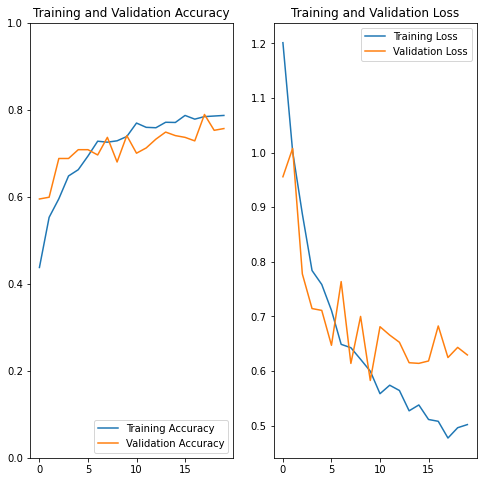

In [18]:
from matplotlib import pyplot as plt

history = best_history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# because of early stopping, can't just use "epochs"
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim([0, 1])

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluate on test data

In [112]:
model = create_model(num_classes=num_classes)

model.load_weights(os.path.join(ckpt_path, "val_acc_0.632.hdf5"))

loss, acc = model.evaluate(test_examples, test_labels)

print('\nevaluate on test set:\nloss = {:.5f}\tacc = {:.3f}%'.format(loss, acc*100))

14/14 [==============================] - ETA: 0s - loss: 0.8977 - accuracy: 0.6307

2022-05-08 23:46:38.230611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 11ms/step - loss: 0.8977 - accuracy: 0.6307

evaluate on test set:
loss = 0.89768	acc = 63.073%


In [151]:
%reset -f